In [1]:
!pip install -U bitsandbytes>=0.46.1

In [2]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 10.3 MB/s eta 0:00:00


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:


from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_LOGIN")
secret_value_1 = user_secrets.get_secret("WANDB_API_KEY")

from huggingface_hub import login
login(token=secret_value_0)

import wandb
wandb.login(key=secret_value_1)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s004 (da24s004-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import os
import torch
from datasets import Dataset
from PIL import Image
from transformers import (
    AutoProcessor, 
    AutoModelForImageTextToText, 
    BitsAndBytesConfig, 
    TrainingArguments, 
    Trainer
)
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig

In [6]:
# --- 1. Configuration ---
# Kaggle dataset path structure for SegPC-2021
DATA_DIR = "/kaggle/input/segpc2021dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/train/train/train" 
IMAGE_DIR = os.path.join(DATA_DIR, "x") # 'x' contains the raw BMP images
MASK_DIR = os.path.join(DATA_DIR, "y")

EVAL_DIR = "/kaggle/input/segpc2021dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/validation/validation"
eIMAGE_DIR = os.path.join(EVAL_DIR, "x")
eMASK_DIR = os.path.join(EVAL_DIR, "y")


In [7]:
MODEL_ID = "google/medgemma-1.5-4b-it"
OUTPUT_DIR = "/kaggle/working/module3_vision_lora"

In [8]:
print("Loading MedGemma 1.5 Processor...")
processor = AutoProcessor.from_pretrained(MODEL_ID)

Loading MedGemma 1.5 Processor...


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [9]:
# --- 2. Custom Dataset Loader ---
def load_segpc_dataset(image_dir, mask_dir):
    data = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.bmp')]
    
    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        
        has_abnormal_cells = os.path.exists(mask_path) 
        answer = "Yes" if has_abnormal_cells else "No"
        
        data.append({
            "image_path": img_path,
            "prompt_text": "Analyze this microscopic bone marrow aspirate. Are there malignant plasma cells present?",
            "answer_text": answer
        })
    return Dataset.from_list(data)

print("Mapping SegPC-2021 images to dataset...")
train_dataset = load_segpc_dataset(IMAGE_DIR, MASK_DIR)
evaluate_dataset = load_segpc_dataset(eIMAGE_DIR, eMASK_DIR)

Mapping SegPC-2021 images to dataset...


In [10]:
import os
import random
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from datasets import Dataset, DatasetDict, Features, Image as HFImage, Value

def build_segpc_hf_dataset(train_x_dir, train_y_dir, val_x_dir, val_y_dir, crop_size=512, multiplier=4):
    """
    Pools, splits, augments, and converts SegPC-2021 WSI patches into a Hugging Face DatasetDict.
    Handles One-to-Many Image-to-Mask relationships.
    """
    print("Pooling and indexing SegPC dataset...")
    
    # 1. Pool all images and dynamically map them to multiple masks
    all_pairs = []
    for d_x, d_y in [(train_x_dir, train_y_dir), (val_x_dir, val_y_dir)]:
        if not os.path.exists(d_x) or not os.path.exists(d_y): continue
        
        # Pre-load the list of all available masks to speed up searching
        available_masks = os.listdir(d_y)
        
        for img_name in os.listdir(d_x):
            if img_name.endswith('.bmp'):
                base_name = os.path.splitext(img_name)[0] # e.g., '106'
                img_path = os.path.join(d_x, img_name)
                
                # Find all corresponding instance masks (e.g., '106_1.bmp', '106_2.bmp')
                prefix = f"{base_name}_"
                exact_name = f"{base_name}.bmp"
                
                matching_mask_paths = [
                    os.path.join(d_y, m) for m in available_masks 
                    if (m.startswith(prefix) or m == exact_name) and m.endswith('.bmp')
                ]
                
                all_pairs.append((img_path, matching_mask_paths))
                
    # 2. Create a robust 85/15 Split
    random.shuffle(all_pairs)
    split_idx = int(len(all_pairs) * 0.85)
    train_pool = all_pairs[:split_idx]
    eval_pool = all_pairs[split_idx:]
    
    print(f"Total Images: {len(all_pairs)} | Training: {len(train_pool)} | Eval: {len(eval_pool)}")

    # 3. Define the Generator Function
    def data_generator(pool, is_training, patch_size=512):
        for img_path, mask_paths in pool:
            raw_img = Image.open(img_path).convert("RGB")
            width, height = raw_img.size
            
            # --- MASK FUSION: Combine all individual cell masks into one global mask ---
            if len(mask_paths) > 0:
                # Start with a completely blank canvas (all zeros/black)
                global_mask_np = np.zeros((height, width), dtype=np.uint8)
                
                for m_path in mask_paths:
                    m_img = Image.open(m_path).convert("L")
                    # Resize just in case a mask dimension is slightly off
                    if m_img.size != (width, height):
                        m_img = m_img.resize((width, height), Image.NEAREST)
                        
                    # Merge mask: If a pixel is white (>0) in ANY mask, keep it white
                    global_mask_np = np.maximum(global_mask_np, np.array(m_img))
                
                raw_mask = Image.fromarray(global_mask_np)
            else:
                raw_mask = None # No cells of interest in this entire slide
            
            # --------------------------------------------------------------------------

            if is_training:
                # --- TRAINING: Random Crops (Data Augmentation) ---
                for _ in range(multiplier):
                    i, j, h, w = T.RandomCrop.get_params(raw_img, output_size=(patch_size, patch_size))
                    final_img = TF.crop(raw_img, i, j, h, w)
                    
                    if raw_mask:
                        cropped_mask = TF.crop(raw_mask, i, j, h, w)
                        has_cells_in_crop = np.max(np.array(cropped_mask)) > 0
                    else:
                        has_cells_in_crop = False
                        
                    # Photometric augmentations
                    if random.random() > 0.5: final_img = TF.hflip(final_img)
                    if random.random() > 0.5: final_img = TF.vflip(final_img)
                    if random.random() > 0.7: 
                        jitter = T.ColorJitter(brightness=0.1, contrast=0.1)
                        final_img = jitter(final_img)

                    label = "Yes" if has_cells_in_crop else "No"
                    yield {"image": final_img, "label": label}

            else:
                # --- EVALUATION: Deterministic Grid (Sliding Window Prep) ---
                for y in range(0, height, patch_size):
                    for x in range(0, width, patch_size):
                        box = (x, y, min(x + patch_size, width), min(y + patch_size, height))
                        patch_img = raw_img.crop(box)
                        
                        # Pad edge patches to maintain the exact tensor size
                        if patch_img.size[0] < patch_size or patch_img.size[1] < patch_size:
                            padded_patch = Image.new("RGB", (patch_size, patch_size), (0, 0, 0))
                            padded_patch.paste(patch_img, (0, 0))
                            patch_img = padded_patch
                            
                        if raw_mask:
                            patch_mask = raw_mask.crop(box)
                            if patch_mask.size[0] < patch_size or patch_mask.size[1] < patch_size:
                                padded_mask = Image.new("L", (patch_size, patch_size), 0)
                                padded_mask.paste(patch_mask, (0, 0))
                                patch_mask = padded_mask
                            has_cells_in_crop = np.max(np.array(patch_mask)) > 0
                        else:
                            has_cells_in_crop = False

                        label = "Yes" if has_cells_in_crop else "No"
                        yield {"image": patch_img, "label": label}

    # 4. Define Hugging Face Features
    features = Features({
        "image": HFImage(),
        "label": Value("string")
    })

    # 5. Build the DatasetDict
    print(f"Generating augmented training set (x{multiplier} multiplier)...")
    train_dataset = Dataset.from_generator(
        data_generator, 
        gen_kwargs={"pool": train_pool, "is_training": True}, 
        features=features
    )
    
    print("Generating evaluation set...")
    eval_dataset = Dataset.from_generator(
        data_generator, 
        gen_kwargs={"pool": eval_pool, "is_training": False}, 
        features=features
    )
    
    return DatasetDict({
        "train": train_dataset,
        "eval": eval_dataset
    })

In [11]:


train_x = '/kaggle/input/segpc2021dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/train/train/train/x'
train_y = '/kaggle/input/segpc2021dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/train/train/train/y'

val_x = '/kaggle/input/segpc2021dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/validation/validation/x'
val_y = '/kaggle/input/segpc2021dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/TCIA_SegPC_dataset/validation/validation/y'

hf_dataset = build_segpc_hf_dataset(train_x, train_y, val_x, val_y)

print(hf_dataset)


Pooling and indexing SegPC dataset...
Total Images: 498 | Training: 423 | Eval: 75
Generating augmented training set (x4 multiplier)...


Generating train split: 0 examples [00:00, ? examples/s]

Generating evaluation set...


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1692
    })
    eval: Dataset({
        features: ['image', 'label'],
        num_rows: 956
    })
})


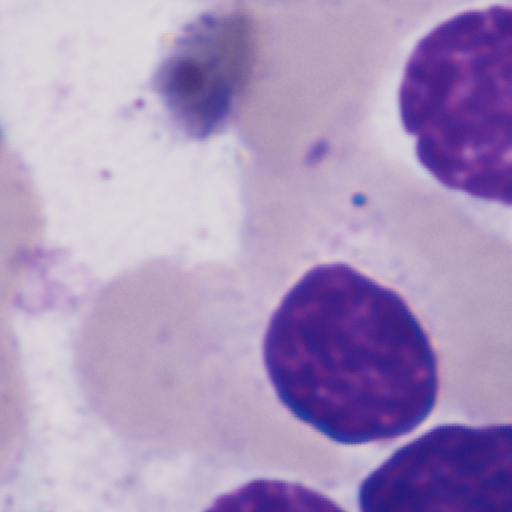

In [12]:
hf_dataset["train"][1]["image"]

In [13]:

from typing import Any

CLASSES = [
    "Yes", "No"
]

options = "\n".join(CLASSES)
PROMPT = f"Analyze this 512x512 Bone Marrow Biopsy patch. Does it contain any plasma cells indicative of Multiple Myeloma?"


def format_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": example["label"],
                },
            ],
        },
    ]
    return example

In [14]:
hf_dataset = hf_dataset.map(format_data)

# Display a processed data sample
hf_dataset["train"][1]

Map:   0%|          | 0/1692 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'label': 'No',
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'Analyze this 512x512 Bone Marrow Biopsy patch. Does it contain any plasma cells indicative of Multiple Myeloma?',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'No', 'type': 'text'}], 'role': 'assistant'}]}

In [15]:
# --- 4. Load Multimodal Model with QLoRA ---
print("Loading MedGemma 1.5 4B in 4-bit precision...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
model = prepare_model_for_kbit_training(model)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading MedGemma 1.5 4B in 4-bit precision...


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

In [16]:
# --- 5. Apply LoRA Adapters ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    task_type="CAUSAL_LM",
)
new_model = get_peft_model(model, lora_config)
new_model.print_trainable_parameters()

trainable params: 32,788,480 || all params: 4,332,867,952 || trainable%: 0.7567


In [17]:
from typing import Any


def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["image"].convert("RGB")])
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [18]:
hf_dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'label': 'Yes',
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'Analyze this 512x512 Bone Marrow Biopsy patch. Does it contain any plasma cells indicative of Multiple Myeloma?',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'Yes', 'type': 'text'}], 'role': 'assistant'}]}

In [19]:
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,            # Directory and Hub repository id to save the model to
    num_train_epochs=1,                       # Number of training epochs
    per_device_train_batch_size=1,                           # Batch size per device during training
    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
    gradient_accumulation_steps=16,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=50,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=50,                                           # Number of steps between evaluations
    learning_rate=2e-4,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler   
    remove_unused_columns = False,  
    report_to="wandb",
    run_name = "medgemma_module3"# Report metrics to tensorboard
                                   # Input keys that correspond to the labels
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [20]:
print("Initializing SFTTrainer...")
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["eval"],
    data_collator=collate_fn,
    processing_class=processor,
    peft_config=lora_config # Pass the tokenizer from the processor
)

Initializing SFTTrainer...


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [21]:
# --- 7. Execute and Save ---
print("Starting Module 3 Multimodal Fine-Tuning...")
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Starting Module 3 Multimodal Fine-Tuning...


wandb: setting up run 55y4ldq0
wandb: Tracking run with wandb version 0.24.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20260222_042606-55y4ldq0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run medgemma_module3
wandb: ⭐️ View project at https://wandb.ai/da24s004-iitm/huggingface
wandb: 🚀 View run at https://wandb.ai/da24s004-iitm/huggingface/runs/55y4ldq0


Step,Training Loss,Validation Loss
50,0.789683,0.052973
100,0.044888,0.045525


TrainOutput(global_step=106, training_loss=0.3961128052675499, metrics={'train_runtime': 16474.7011, 'train_samples_per_second': 0.103, 'train_steps_per_second': 0.006, 'total_flos': 1.117456995485376e+16, 'train_loss': 0.3961128052675499})

In [22]:
print(f"Saving Vision LoRA adapter to {OUTPUT_DIR}...")
trainer.model.save_pretrained(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
print("✅ Module 3 successfully compiled according to Google Health standards!")

Saving Vision LoRA adapter to /kaggle/working/module3_vision_lora...
✅ Module 3 successfully compiled according to Google Health standards!
